Runs the CPF-SAEM algorithm,

  F. Lindsten, "An efficient stochastic approximation EM algorithm
   using conditional particle filters", Proceedings of the 38th
   International Conference on Acoustics, Speech, and Signal Processing
   (ICASSP), Vancouver, Canada, May 2013.

The resample code is for resampling the weights. If we consider the Roulette Wheel, the larger weight (larger part in Roulette Wheel) will be preferred (more likely to be picked). NOTE: this algorithm is NOT computational efficiently!

In [1]:
import numpy as np

def resample(weights):
    n = len(weights)
    indices = []
    qc = [sum(weights[:i+1]) for i in range(n)]
    #u = np.random.normal(0, 1, n)
    qc = qc/np.sum(weights)
    #print(qc)
    
    return np.searchsorted(qc, np.random.random(n))


Use the following two cells to define the functions (f,y). In this example, the functions are taken as the common examples in the 'space-state' model, where f represents how far a robot moves, and y denotes the oritation (or messure). Note here, the functions do NOT contain random variables. These random variables will be added in the generate_data function.

In [5]:
def f(xt,t):
    xt_new = 0.5*xt + 25*xt/(1+xt**2) + 8*np.cos(1.2*t)
    return xt_new 
def h(xt):
    yt = xt**2/20
    return yt

The followings are the main parts of the CPF_SAEM algorithm.

In [6]:
def cpf_as(y, q, r, N, X):
    T = len(y)
    x = np.zeros((N,T))
    a = np.zeros((N,T))
    w = np.zeros((N,T))
    x[:,0] = 0
    x[N-1,0] = X[0]
    for t in range(0,T):
        if t!=0:
            ind = resample(w[:,t-1])
            ind = ind[np.random.permutation(N)]
            xpred = f(x[:,t-1],t-1)
            x[:,t] = xpred[ind] + np.sqrt(q)*np.random.normal(0, 1, N)
            # if the value of X is provided, then do the following, otherwise, an unconditional PF should run.
            # if X provide:
            x[N-1,t] = X[t]
            # the following is Ancestor sampling (ancestor sampling may have another name, check!)
            m = np.exp(-1/2/q*(X[t]-xpred)**2)
            w_as = w[:,t-1]*m
            w_as = w_as/np.sum(w_as)
            ind[N-1] = np.where(np.random.uniform(0,1,1)<np.cumsum(w_as))[0][0] 
            a[:,t] = ind        
        # for the important weights
        ypred = h(x[:,t])
        logweights = -1/2/r*(y[t]-ypred)**2
        const = np.max(logweights)
        weights = np.exp(logweights - const) # Subtract the maximum value for numerical stability
        w[:,t] = weights/sum(weights)
        
    ind = [int(x) for x in a[:,T-1]]
    
    for t in range(T-2,0,-1):
        x[:,t] = x[ind,t]
        ind = [int(x) for x in a[ind,t]]
    return x, w

In [7]:
def update_S(S,X,w,gamma,y):
    (N,T) = X.shape
    fX = f(X[:,0:T-1],np.tile(np.array([x for x in range(0,T-1)]), (N,1)))
    S1 = np.mean((X[:,1:T]-fX)**2,1)
    S1 = np.matmul(np.transpose(S1),w)
    hX = h(X)
    S2 = np.mean((np.tile(np.transpose(y), (N,1))-hX)**2,1)
    S2 = np.matmul(np.transpose(S2),w)
    S = (1-gamma)*S + gamma*np.vstack((S1,S2))
    return S

In [8]:
def cpf_saem(numIter, y, N, gamma, qinit, rinit, q0, r0):
    T = len(y)
    q = np.zeros((numIter,1))
    r = np.zeros((numIter,1))
    X = np.zeros((numIter,T))
    q[0] = qinit
    r[0] = rinit
    particles, w = cpf_as(y, q[0], r[0], N, X[0,:])
    J = np.where(np.random.uniform(0,1,1)<np.cumsum(w[:,T-1]))[0][0]
    X[1,:] = particles[J,:]
    S = np.array([0,0]).reshape(2,1)
    for k in range(1,numIter-1):
        S = update_S(S, particles, w[:,T-1], gamma[k], y)
        q[k] =S[0][0]
        r[k] = S[1][0]
        particles, w = cpf_as(y, q[k], r[k], N, X[k-1,:])
        J = np.where(np.random.uniform(0,1,1)<np.cumsum(w[:,T-1]))[0][0]
        X[k,:] = particles[J,:]
    return X,q,r

In [9]:
def generate_data(T,q,r):
    x = np.zeros((T, 1))
    y = np.zeros((T, 1))
    x[0] = 0 # Initial condition
    for t in range(0,T-1):
        x[t+1] = f(x[t],t) + np.sqrt(q)*np.random.normal(0, 1, 1);
        y[t] = h(x[t]) + np.sqrt(r)*np.random.normal(0, 1, 1);
    return x,y

In [10]:
N1 = 15            
T = 100
numIter = 200 # Number of iterations in EM algorithms
kappa = 1

In [11]:
%matplotlib inline 

In [12]:
q0 = 0.1 # True process noise variance
r0 = 1 # True measurement noise variance
x0,y0 = generate_data(T,q0,r0)

In [13]:
print(x0.shape)
print(y0.shape)

(100, 1)
(100, 1)


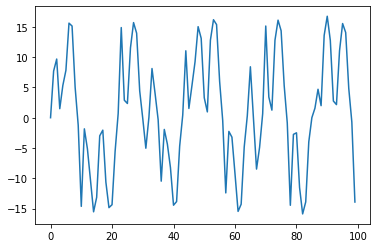

In [14]:
import matplotlib.pyplot as plt
plt.plot(np.arange(100),x0)
plt.show()

In [15]:
qinit = 1
rinit = 0.1

In [16]:
gamma = np.zeros((1,numIter))[0]
gamma[0:1] = 1
gamma[1:99] = 0.98
gamma[99:] = 0.98*((np.arange(0,numIter-99)+kappa)/kappa)**(-0.7)

In [17]:
X1, q1, r1 = cpf_saem(numIter, y0, N1, gamma, qinit, rinit, q0, r0)

In [18]:
print(len(q1))

200


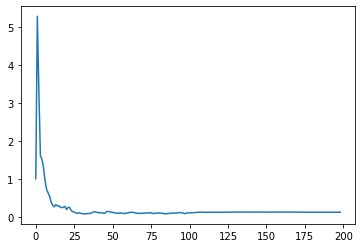

In [19]:
plt.plot(np.arange(len(q1)-1),q1[:-1])
plt.show()

In [20]:
print(q1[-5:-1])

[[0.11662978]
 [0.11681299]
 [0.11731685]
 [0.11790288]]


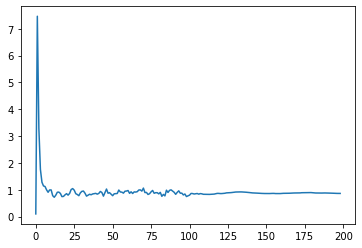

In [21]:
plt.plot(np.arange(len(r1)-1),r1[:-1])
plt.show()

In [22]:
print(r1[-5:-1])

[[0.86557749]
 [0.86439716]
 [0.86218468]
 [0.8632751 ]]


[[0.09431043]]
[[0.09038187]]
[[0.10083137]]
[[0.09475556]]
[[0.11696053]]
[[0.10449606]]
[[0.10519356]]
[[0.12937312]]
[[0.12134095]]
[[0.09968126]]
[[0.1093625]]
[[0.11982777]]
[[0.08462502]]
[[0.08033977]]
[[0.12684055]]
[[0.11740446]]
[[0.10160556]]
[[0.09640011]]
[[0.10342799]]
[[0.11502798]]


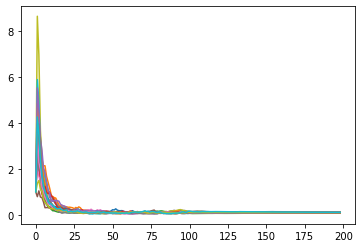

In [23]:
for _ in range(20):
    X1, q1, r1 = cpf_saem(numIter, y0, N1, gamma, qinit, rinit, q0, r0)
    print(q1[-2:-1])
    plt.plot(np.arange(len(q1)-1),q1[:-1])
plt.show()

[[0.89001188]]
[[0.90230926]]
[[0.87659031]]
[[0.88237546]]
[[0.86478528]]
[[0.91548479]]
[[0.88205485]]
[[0.90999077]]
[[0.88435592]]
[[0.86571355]]
[[0.85369995]]
[[0.86321011]]
[[0.87206416]]
[[0.85807413]]
[[0.85456554]]
[[0.85608251]]
[[0.91454758]]
[[0.89627115]]
[[0.87382841]]
[[0.9076523]]


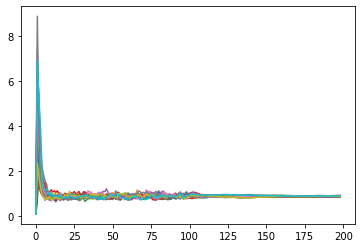

In [24]:
for _ in range(20):
    X1, q1, r1 = cpf_saem(numIter, y0, N1, gamma, qinit, rinit, q0, r0)
    print(r1[-2:-1])
    plt.plot(np.arange(len(r1)-1),r1[:-1])
plt.show()